<a href="https://colab.research.google.com/github/amantayal44/seq2seq-chatbot/blob/master/Decoder_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Transformer using TPUs

In this notebook we train simple transformer model on cornell movie dialogue corpus using TPUs and use it for chatbot task

**Note**: Change Runtime type to TPU

## loading files from git repo

In [1]:
!git clone https://github.com/amantayal44/seq2seq-chatbot.git

Cloning into 'seq2seq-chatbot'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 2), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [2]:
!cp seq2seq-chatbot/* .

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from dataset_2 import *
from main import *
from model import *

## TPU/GPU initialization

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

Running on TPU ['10.15.33.58:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.15.33.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.15.33.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


## Loading Dataset

We use max samples 70,000 so after filtering and spliting in test,train dataset, train dataset has about 50,000 examples

In [3]:
max_samples = 70000
max_length = 40
batch_size = 64* strategy.num_replicas_in_sync

dataset,test_dataset,tokenizer,meta = get_dataset(max_samples,max_length,batch_size,validation_split = 0.2)

In [4]:
#train_dataset size
len(list(dataset.as_numpy_iterator())) * batch_size

50176

In [5]:
a = list(dataset.as_numpy_iterator())

In [7]:
a[0][0][0]

array([8109,   55,    2,    5,  134,   56,  756,    1,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0, 8110,  354,    2,
        102,  417,    9,    6,  632,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

 ## Hyperparameters 

In [9]:
d_model = 256
dff = 1024
num_layers = 8
num_heads = 8
vocab_size = meta['vocab_size']

In [10]:
vocab_size

8112

## Loss and Accuracy function

In [11]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_length*2+1))
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [12]:
def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, max_length*2+1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true[:,max_length:], y_pred[:,max_length:])


## Optimizer for transformer
transformer has optimizer with custom learning rate

In [13]:
optimizer = tf.keras.optimizers.Adam(
        CustomSchedule(d_model),beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Initializing and compiling transformer model

In [14]:
tf.keras.backend.clear_session()

with strategy.scope():
  model = decoder_only(d_model,vocab_size,num_layers,num_heads,dff)
  model.compile(optimizer=optimizer,loss=loss_function,metrics=[accuracy])

In [15]:
model.summary()

Model: "decoder_only"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    2076672     decoder_inputs[0][0]             
__________________________________________________________________________________________________
tf_op_layer_Mul (TensorFlowOpLa [(None, None, 256)]  0           embedding[0][0]                  
__________________________________________________________________________________________________
positional_encoding (Positional (None, None, 256)    0           tf_op_layer_Mul[0][0]            
_______________________________________________________________________________________

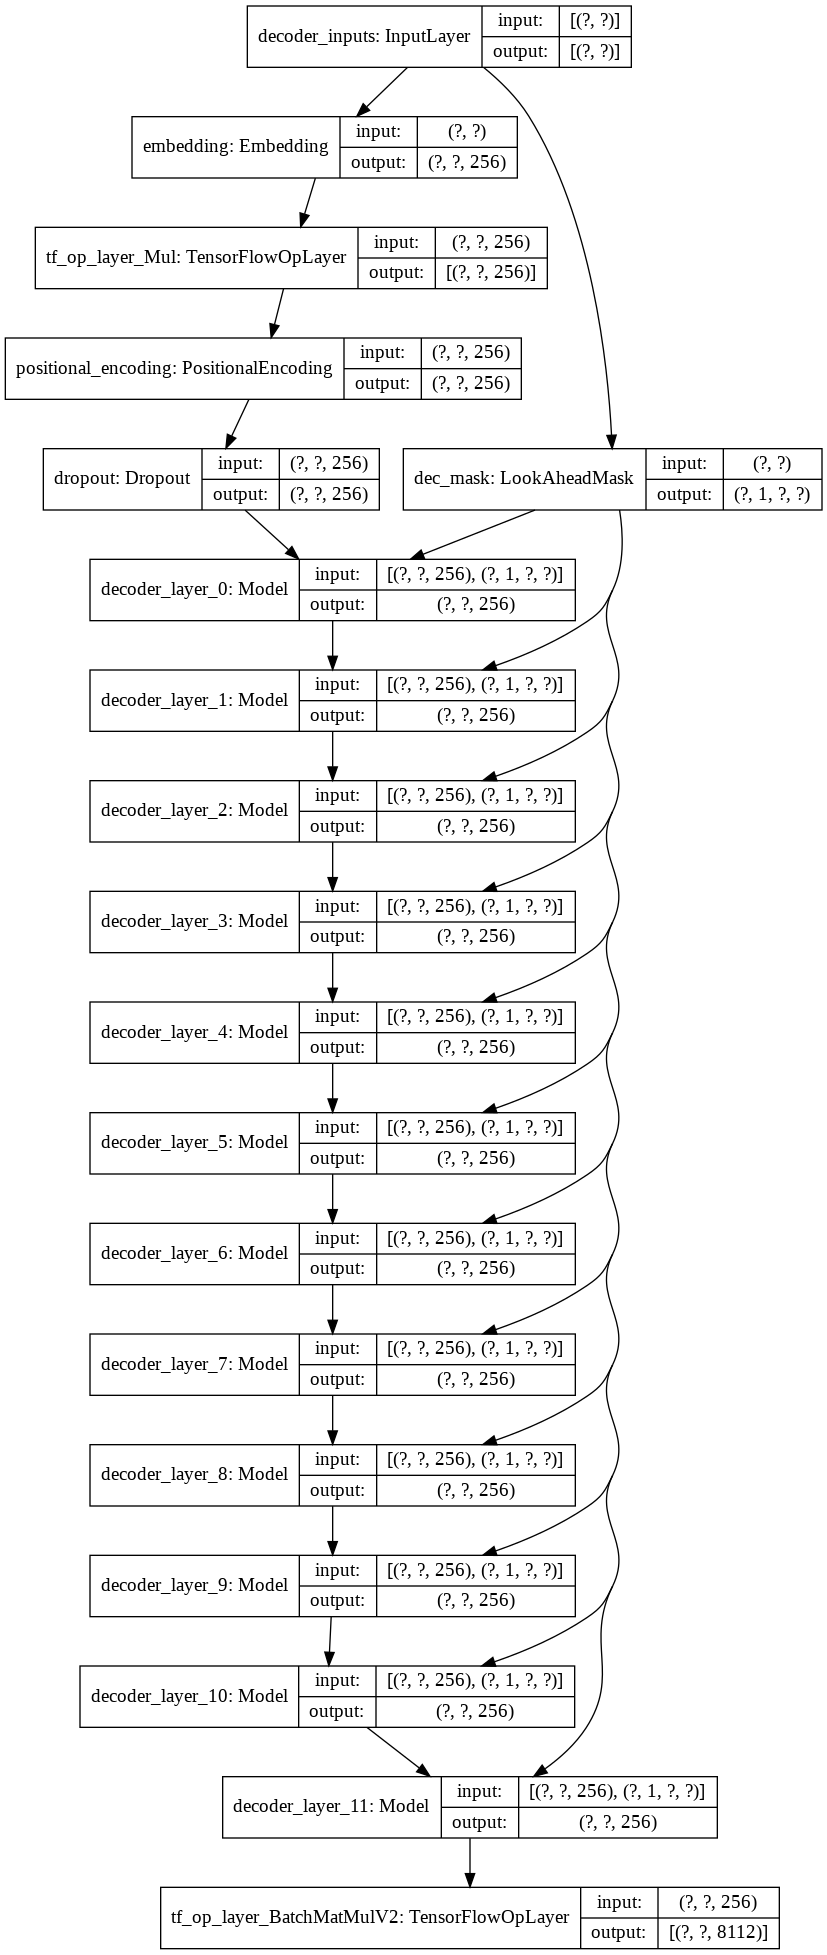

In [15]:
tf.keras.utils.plot_model(model,show_shapes=True)

## Training

In [16]:
Epochs = 40
history = model.fit(dataset,epochs=Epochs,validation_data=test_dataset)

Epoch 1/40
98/98 [==============================] - 33s 338ms/step - accuracy: 0.0134 - loss: 2.6296 - val_accuracy: 0.0249 - val_loss: 2.5233
Epoch 2/40
98/98 [==============================] - 10s 98ms/step - accuracy: 0.0235 - loss: 2.3782 - val_accuracy: 0.0464 - val_loss: 2.2055
Epoch 3/40
98/98 [==============================] - 10s 98ms/step - accuracy: 0.0506 - loss: 2.0220 - val_accuracy: 0.0580 - val_loss: 1.8759
Epoch 4/40
98/98 [==============================] - 10s 98ms/step - accuracy: 0.0602 - loss: 1.8037 - val_accuracy: 0.0631 - val_loss: 1.7489
Epoch 5/40
98/98 [==============================] - 10s 98ms/step - accuracy: 0.0641 - loss: 1.6941 - val_accuracy: 0.0661 - val_loss: 1.6504
Epoch 6/40
98/98 [==============================] - 9s 97ms/step - accuracy: 0.0669 - loss: 1.6157 - val_accuracy: 0.0687 - val_loss: 1.5907
Epoch 7/40
98/98 [==============================] - 9s 96ms/step - accuracy: 0.0685 - loss: 1.5676 - val_accuracy: 0.0700 - val_loss: 1.5537
Epoch 8

## Evaluation

In [ ]:
evaluate(model,tokenizer,meta)


Evaluate

input: Hi, How are you
output: hey , lover . whatcha doing ?

input: Will you marry me
output: no . i promise . i will do my best .

input: where did you visit in london
output: the situation is perfectly impressive . i do not have to be pratt . i am a reasonable price of a oriites in the middle of a survivent man .

input: the situation is perfectly impressive . i do not have to be pratt . i am a reasonable price of a oriites in the middle of a survivent man .
output: that is not a problem , jeff . but this is about as long as i am incurable , i am afraid to keep your hair on the south city .

input: that is not a problem , jeff . but this is about as long as i am incurable , i am afraid to keep your hair on the south city .
output: save it . everything is fine . everything is fine . everything is fine . let us go .

input: save it . everything is fine . everything is fine . everything is fine . let us go .
output: bye .

input: bye .
output: bye .


## Plotting accuracy and loss graph

In [ ]:
def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history['accuracy'])

    acc = history['accuracy'][:steps]
    val_acc =history['val_accuracy'][:steps]
    loss = history['loss'][:steps]
    val_loss = history['val_loss'][:steps]
        
    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(acc, c='#0c7cba', label='Train Acc')
    plt.plot(val_acc, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(acc), 5))
    plt.xlim(0, len(acc))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (acc[-1], val_acc[-1]), fontsize=12)
    plt.legend()

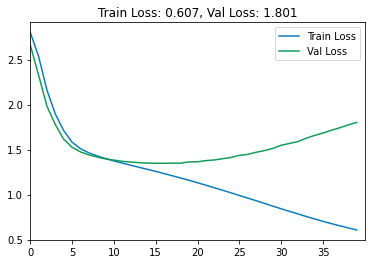

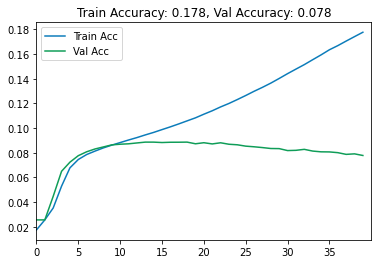

In [ ]:
plot_compare(history.history)

val loss function decreases till about 15 epochs, so model overfitted training dataset.So that shows we should use more samples or less epoch... try changing epochs or sample size

## ChatBot

In [ ]:
def chatbot(sentence):
  ans = predict(model,tokenizer,sentence,meta)
  print("Q: {}\nA: {}\n".format(sentence,ans))

In [ ]:
chatbot('are you mad at me')

Q: are you mad at me
A: never . . . no i am no fucking dead !



In [ ]:
chatbot('lets play something')

Q: lets play something
A: you were not gonna mention that name .



In [ ]:
chatbot('hey you fuck off')

Q: hey you fuck off
A: i am not sure , you are right .



In [ ]:
chatbot('do you know what are you saying?')

Q: do you know what are you saying?
A: i do not know .



## Saving model weights, tokenizer in Google drive

In [ ]:
model.save_weights('transformer_weights.h5')

In [ ]:
tokenizer.save_to_file('tokenizer')

In [ ]:
save_pickle(meta,'meta')

In [ ]:
save_pickle(history.history,'history_transformer')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!cp transformer_weights.h5 '/content/gdrive/My Drive/transformer_weights.h5'
!cp tokenizer.subwords '/content/gdrive/My Drive/tokenizer.subwords'
!cp meta.pickle '/content/gdrive/My Drive/meta.pickle'

In [18]:
def inference1(model,tokenizer,sentence,meta):

    sentence = preprocess_sentence(sentence)
    ques = tokenizer.encode(sentence)
    ques = ques+[0]*(max_length-len(ques))
    sentence = tf.expand_dims(meta['start_token'] + ques + meta['sep_token'],axis = 0)

    for i in range(meta['max_length']):
        prediction = model(sentence,training=False)
        #select last word
        prediction = prediction[:,-1:,:]
        prediction_id = tf.cast(tf.argmax(prediction,axis=-1),tf.int32)
        # print(prediction_id)

        if tf.equal(prediction_id,meta['end_token']):
            break
        sentence = tf.concat([sentence,prediction_id],axis=-1)
    print(sentence)
    return tf.squeeze(sentence,axis=0)

In [21]:
def predict(model,tokenizer,sentence,meta):
    prediction = inference1(model,tokenizer,sentence,meta)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size and i>0])

    return predicted_sentence

In [27]:
predict(model,tokenizer,"fuck off",meta)

tf.Tensor(
[[8109  243  280    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 8110
     3   24  114   23   24  114   23   24  114   23   17  114   23   17
   114   23   17  114   23 1632]], shape=(1, 62), dtype=int32)


'fuck off , am gonna  ? am gonna  ? am gonna  ? are gonna  ? are gonna  ? are gonna  ? anywhere'

In [44]:
tokenizer.decode([' , '])

' , '